In [2]:
import importlib

importlib.import_module("make_blocks")
from make_blocks import *

importlib.import_module("plotfun")
import warnings
warnings.filterwarnings('ignore')

importlib.import_module("get_all_fun_used")
from get_all_fun_used import *

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set_context('notebook')
#%config InlineBackend.figure_format = 'retina'

from operator import itemgetter, attrgetter
import os

os.chdir('/NS/social-net-blockchain/work/vpahari/block500/code/code/wfq_pickle_files')
import importlib

importlib.import_module("block")
from block import *

importlib.import_module("transaction")
from transaction import *

os.chdir('/NS/social-net-blockchain/work/vpahari/block500/code/code')

from plotfun import *
importlib.import_module("utils_plot")
from notebook_utils_plot import *


/home/vpahari/anaconda3/bin/python
/home/vpahari/anaconda3/bin/python
/home/vpahari/anaconda3/bin/python


# Background

The purpose of this notebook is to generate plots to show the error of our GPS approximation system.

We took snapshots queues while running our simulation, where we put transactions into the queue and remove it. For each simulation, we took 50 different snapshots.

Using these snapshots and whether the transactions were offered as open or dark, we calculate the expected waiting time of each according to our GPS approximation system. This gives us the expected waiting time of each transaction in the simulation.

We also begin to remove transactions from the queue and calculate how long each transaction had to wait before being included. The probability that an MPO mines the next block is its hashrate. 
Using this, we ran 5,000 different simulations, where we mined all the transactions into a block. 
Taking the mean of this value gives us the actual waiting time of a transaction. We calculate the actual waiting time through simulations because otherwise we would need to enumerate through all the possibilities and their probabilities that would lead to the transaction being mined.  

We try to see how close our GPS approximation system for expected waiting time is to the actual waiting time (calculated fromt the simulations).






In [3]:

# Returns the block number of the saved files 
# The block number corresponds to the point at which the snapshot of each MPO was taken
def get_glob_name(nummpo, h):
    num_list = []
    for pickle_name in glob.glob("wfq_pickle_files/waittime_pickle_files/wait_time_dict_" + str(nummpo) + "_" + str(h) + "_" "*.pickle"):
        curr_num_list = pickle_name.split("_")
        curr_num = int(curr_num_list[-1].split(".")[0])
        num_list.append(curr_num)
    return num_list
        

# Return a dictionary for a given number of MPO and hashrate where:
# keys : the block number
# value : is the set of transaction id in the queue

# The purpose of this function is to return a list of open and dark fee transactions that correspond to each MPO saved at a block number
def get_open_dark_tx_set(nummpo,h):
    
    num_list_curr = get_glob_name(nummpo, h)
    
    dict_open = {}
    dict_dark = {}
    
    for num_block in num_list_curr:
        
        set_open = set()
        set_dark = set()
        str_to_use_now = "wfq_pickle_files/picklefiles2/MPO_" + str(nummpo) + "/hlist=" + str(h) + "/between_" + str(nummpo) + "_wfq_" + str(h) + "_blockround_" + str(num_block) + "len_20.pickle"
        
        with open(str_to_use_now, "rb") as openfile:
            curr_MPO_list = pickle.load(openfile)
            
        for MPO in curr_MPO_list:
            for tx in MPO.MPO_hidden_queue.queue:
                if tx.isOpen:
                    set_open.add(tx.txid)
                else:
                    set_dark.add(tx.txid)

        num_block_int = int(num_block)
        dict_open[num_block_int] = set_open
        dict_dark[num_block_int] = set_dark 
        
    return dict_open, dict_dark
            
    
# sim_dict, exp_dict are dictionary where
# the key is the transaction id 
# the value is a list of waiting time from simulations and expected waiting time from the GPS approximation respectively

# set_to_check is the set of transaction id to check. This is there because we divide the set of all transactions
# into open and dark transactions

# Function returns the list of absolute difference and relative difference between:
# Actual waiting time (from simulations) and Expected waiting time (from GPS approximation)
def return_diff_and_perc_for_set(sim_dict, exp_dict, set_to_check):
    
    diff_list = []
    perc_list = []
    
    for k in exp_dict:
        
        if k not in set_to_check:
            continue
        
        curr_l = np.mean(sim_dict[k])
        curr_exp = exp_dict[k]
        diff_mean_exp = abs(curr_l - curr_exp)
        percentage_diff = diff_mean_exp / curr_exp
        diff_list.append(diff_mean_exp)
        perc_list.append(percentage_diff)
        
    return diff_list, perc_list


# iven the number of MPO and the hashrate list

# Returns a dictionary where the key is a block number and the value is the absolute and percentage error of each transactions
# where the actual waiting time was calculated from simulations
# Expected waiting time was calculated by GPS approximations
def open_dark_error(nummpo,h):
    
    dict_open, dict_dark = get_open_dark_tx_set(nummpo,h)
    num_list_curr = get_glob_name(nummpo, h)
    d_perc_list_open = {}
    d_perc_list_dark = {}
    d_actual_list_open = {}
    d_actual_list_dark = {}
    
    for num_block in num_list_curr:
        
        with open("wfq_pickle_files/waittime_pickle_files/wait_time_dict_" + str(nummpo) + "_" + str(h) + "_" + str(num_block) + ".pickle", "rb") as openfile:
            wait_time_dict = pickle.load(openfile)
        with open("wfq_pickle_files/waittime_pickle_files/exp_time_dict_" + str(nummpo) + "_" + str(h) + "_" + str(num_block) + ".pickle", "rb") as openfile:
            exp_time_dict = pickle.load(openfile)
            
        big_perc_list_open = []
        big_perc_list_dark = []
        big_actual_list_open = []
        big_actual_list_dark = []
            
        for i in range(len(wait_time_dict)):
            diff_list_open, perc_list_open = return_diff_and_perc_for_set(wait_time_dict[i], exp_time_dict[i], dict_open[num_block])
            diff_list_dark, perc_list_dark = return_diff_and_perc_for_set(wait_time_dict[i], exp_time_dict[i], dict_dark[num_block])
            big_perc_list_open.append(perc_list_open)
            big_perc_list_dark.append(perc_list_dark)
            big_actual_list_open.append(diff_list_open)
            big_actual_list_dark.append(diff_list_dark)
            
        d_perc_list_open[num_block] = big_perc_list_open
        d_perc_list_dark[num_block] = big_perc_list_dark
        d_actual_list_open[num_block] = big_actual_list_open
        d_actual_list_dark[num_block] = big_actual_list_dark
        
    return d_perc_list_open, d_perc_list_dark,  d_actual_list_open,  d_actual_list_dark
    

# Error Calculation

Using the functions above, we check the error of the follwing 12 simulations with different parameters. We are trying to calculate the mean absolute error and mean percentage error across our simulations for our GPS approximation. 

In [4]:
d_open_4, d_dark_4, d_open_actual_4, d_dark_actual_4 = open_dark_error(4,0.35)
d_open_5, d_dark_5, d_open_actual_5, d_dark_actual_5 = open_dark_error(5,0.3)
d_open_6, d_dark_6, d_open_actual_6, d_dark_actual_6 = open_dark_error(6,0.25)
d_open_7, d_dark_7, d_open_actual_7, d_dark_actual_7 = open_dark_error(7,0.2)

d_open_4_5, d_dark_4_5, d_open_actual_4_5, d_dark_actual_4_5 = open_dark_error(4,0.5)
d_open_5_5, d_dark_5_5, d_open_actual_5_5, d_dark_actual_5_5 = open_dark_error(5,0.5)
d_open_6_5, d_dark_6_5, d_open_actual_6_5, d_dark_actual_6_5 = open_dark_error(6,0.5)
d_open_7_5, d_dark_7_5, d_open_actual_7_5, d_dark_actual_7_5 = open_dark_error(7,0.5)

d_open_4_3, d_dark_4_3, d_open_actual_4_3, d_dark_actual_4_3 = open_dark_error(4,0.26)
d_open_5_3, d_dark_5_3, d_open_actual_5_3, d_dark_actual_5_3 = open_dark_error(5,0.21)
d_open_6_3, d_dark_6_3, d_open_actual_6_3, d_dark_actual_6_3 = open_dark_error(6,0.17)
d_open_7_3, d_dark_7_3, d_open_actual_7_3, d_dark_actual_7_3 = open_dark_error(7,0.1455)

In [5]:
# Calculate the mean error given a dictionary
def open_dark_mean_error(curr_d):

    curr_full_l = []
    curr_ave_l = []

    for k in curr_d:

        curr_l = curr_d[k][0]
        curr_mean = np.mean(curr_l)
        curr_full_l += curr_l
        curr_ave_l.append(curr_mean)

    return curr_full_l

# Calculate the mean error given a list of dictionaries
def open_dark_mean_error_list(curr_d_list):  

    curr_full_l = []
    curr_ave_l = []
    
    for curr_d in curr_d_list:
        for k in curr_d:

            curr_l = curr_d[k][0]
            curr_mean = np.mean(curr_l)
            curr_full_l += curr_l
            curr_ave_l.append(curr_mean)

    return curr_full_l






# Error of open and dark fee transactions

Here we divide the error calculation for open and dark fee transactions, in order to see how well the GPS approximation performs for the two different kinds of transactions.

In [6]:
all_sim_list_open = [d_open_4,d_open_5,d_open_6,d_open_7,d_open_4_5,d_open_5_5,d_open_6_5,d_open_7_5,d_open_4_3,d_open_5_3,d_open_6_3,d_open_7_3]
all_sim_list_dark = [d_dark_4,d_dark_5,d_dark_6,d_dark_7,d_dark_4_5,d_dark_5_5,d_dark_6_5,d_dark_7_5,d_dark_4_3,d_dark_5_3,d_dark_6_3,d_dark_7_3]

all_sim_list_open_actual = [d_open_actual_4,d_open_actual_5,d_open_actual_6,d_open_actual_7,d_open_actual_4_5,d_open_actual_5_5,d_open_actual_6_5,d_open_actual_7_5,d_open_actual_4_3,d_open_actual_5_3,d_open_actual_6_3,d_open_actual_7_3]
all_sim_list_dark_actual = [d_dark_actual_4,d_dark_actual_5,d_dark_actual_6,d_dark_actual_7,d_dark_actual_4_5,d_dark_actual_5_5,d_dark_actual_6_5,d_dark_actual_7_5,d_dark_actual_4_3,d_dark_actual_5_3,d_dark_actual_6_3,d_dark_actual_7_3]

all_sim_open = open_dark_mean_error_list(all_sim_list_open)
all_sim_dark = open_dark_mean_error_list(all_sim_list_dark)

all_sim_open_actual = open_dark_mean_error_list(all_sim_list_open_actual)
all_sim_dark_actual = open_dark_mean_error_list(all_sim_list_dark_actual)


In [7]:
print("NUM DATA POINTS")
print(len(all_sim_open))
print(len(all_sim_dark))
print(len(all_sim_dark) + len(all_sim_open))


print("PERCENTAGE ERROR DATA")
print(np.mean(all_sim_open))
print(np.mean(all_sim_dark))
print(np.mean(all_sim_open + all_sim_dark))


print("ABSOLUTE ERROR DATA")
print(np.mean(all_sim_open_actual))
print(np.mean(all_sim_dark_actual))
print(np.mean(all_sim_open_actual + all_sim_dark_actual))

NUM DATA POINTS
4564
15209
19773
PERCENTAGE ERROR DATA
0.09272490811446038
0.007437109788652897
0.027123222748698682
ABSOLUTE ERROR DATA
2.121597398626554
0.22794181097008973
0.6650350240416572


In [8]:
import matplotlib.ticker

def plot_png_pdf_cdf(l,savename,xlabel):
    
    plot_cdf(l, x_label=xlabel, y_label='CDF')
    plt.savefig('wfq_pickle_files/paper_figs/Open_Actual_Error_CDF_4_0.5' + '.png', bbox_inches = 'tight')
    plt.show()
    plt.clf()
    
    plot_cdf(l, x_label=xlabel, y_label='CDF')
    plt.savefig('wfq_pickle_files/paper_figs/Open_Actual_Error_CDF_4_0.5' + '.pdf', bbox_inches = 'tight')
    plt.show()
    plt.clf()
    
    
def make_ax_cdf(open_list, closed_list, savename, xlabel,limbool):
    
    full_list = open_list + closed_list
    
    ax = plot_cdf(open_list, x_label=xlabel, y_label='CDF', label = 'Open txs', style='-')
    #ax = plot_cdf(open_list, x_label=xlabel, y_label='CDF', label = 'Open')
    ax = plot_cdf(closed_list, x_label=xlabel, y_label='CDF', label = 'Dark txs', ax = ax, style='--')
    #ax = plot_cdf(closed_list, x_label=xlabel, y_label='CDF', label = 'Dark', ax = ax)
    ax = plot_cdf(full_list, x_label=xlabel, y_label='CDF', label = 'All txs', ax = ax, style=':')
    #ax = plot_cdf(full_list, x_label=xlabel, y_label='CDF', label = 'All', ax = ax)
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
    
    plt.legend()
    if limbool:
        plt.xlim(-0.05,1)
    plt.savefig(savename, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    
    
    
    

# Result

We see that our approximation works well for dark fee transactions. However, there is a larger error for the open fee transactions. This is because our GPS approximation system because adding a transaction to a queue does not strictly decrease the expected waiting time (it is the same sometimes). This means that in some cases, the GPS approximation does not take into account that the transaction can be mined by another MPO.

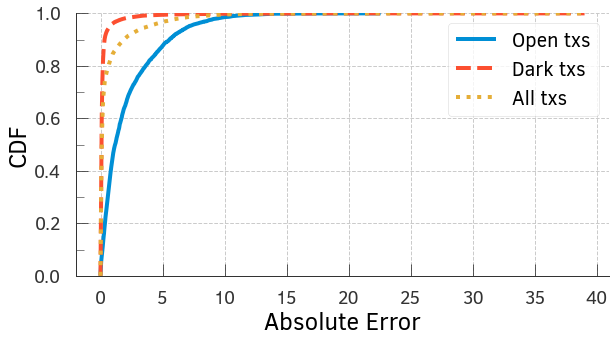

<Figure size 612x324 with 0 Axes>

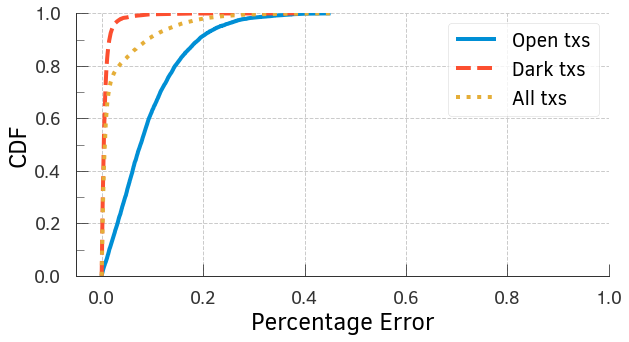

<Figure size 612x324 with 0 Axes>

In [9]:
make_ax_cdf(all_sim_open_actual, all_sim_dark_actual, 'wfq_pickle_files/figures_for_paper/error/Error_all_actual.pdf','Absolute Error',False)

make_ax_cdf(all_sim_open, all_sim_dark, 'wfq_pickle_files/figures_for_paper/error/Error_all_percentage.pdf','Percentage Error',True)


# Individual Results

Here we plot the CDF of the absolute and percentage error of each 12 individual simulations. 

In [12]:
d_open_4, d_dark_4, d_open_actual_4, d_dark_actual_4 = open_dark_error(4,0.35)
d_open_5, d_dark_5, d_open_actual_5, d_dark_actual_5 = open_dark_error(5,0.3)
d_open_6, d_dark_6, d_open_actual_6, d_dark_actual_6 = open_dark_error(6,0.25)
d_open_7, d_dark_7, d_open_actual_7, d_dark_actual_7 = open_dark_error(7,0.2)

open_perc_error_4 = open_dark_mean_error(d_open_4)
open_perc_error_5 = open_dark_mean_error(d_open_5)
open_perc_error_6 = open_dark_mean_error(d_open_6)
open_perc_error_7 = open_dark_mean_error(d_open_7)

dark_perc_error_4 = open_dark_mean_error(d_dark_4)
dark_perc_error_5 = open_dark_mean_error(d_dark_5)
dark_perc_error_6 = open_dark_mean_error(d_dark_6)
dark_perc_error_7 = open_dark_mean_error(d_dark_7)

open_actual_error_4 = open_dark_mean_error(d_open_actual_4)
open_actual_error_5 = open_dark_mean_error(d_open_actual_5)
open_actual_error_6 = open_dark_mean_error(d_open_actual_6)
open_actual_error_7 = open_dark_mean_error(d_open_actual_7)

dark_actual_error_4 = open_dark_mean_error(d_dark_actual_4)
dark_actual_error_5 = open_dark_mean_error(d_dark_actual_5)
dark_actual_error_6 = open_dark_mean_error(d_dark_actual_6)
dark_actual_error_7 = open_dark_mean_error(d_dark_actual_7)

d_open_4_5, d_dark_4_5, d_open_actual_4_5, d_dark_actual_4_5 = open_dark_error(4,0.5)
d_open_5_5, d_dark_5_5, d_open_actual_5_5, d_dark_actual_5_5 = open_dark_error(5,0.5)
d_open_6_5, d_dark_6_5, d_open_actual_6_5, d_dark_actual_6_5 = open_dark_error(6,0.5)
d_open_7_5, d_dark_7_5, d_open_actual_7_5, d_dark_actual_7_5 = open_dark_error(7,0.5)

open_perc_error_4_5 = open_dark_mean_error(d_open_4_5)
open_perc_error_5_5 = open_dark_mean_error(d_open_5_5)
open_perc_error_6_5 = open_dark_mean_error(d_open_6_5)
open_perc_error_7_5 = open_dark_mean_error(d_open_7_5)

dark_perc_error_4_5 = open_dark_mean_error(d_dark_4_5)
dark_perc_error_5_5 = open_dark_mean_error(d_dark_5_5)
dark_perc_error_6_5 = open_dark_mean_error(d_dark_6_5)
dark_perc_error_7_5 = open_dark_mean_error(d_dark_7_5)

open_actual_error_4_5 = open_dark_mean_error(d_open_actual_4_5)
open_actual_error_5_5 = open_dark_mean_error(d_open_actual_5_5)
open_actual_error_6_5 = open_dark_mean_error(d_open_actual_6_5)
open_actual_error_7_5 = open_dark_mean_error(d_open_actual_7_5)

dark_actual_error_4_5 = open_dark_mean_error(d_dark_actual_4_5)
dark_actual_error_5_5 = open_dark_mean_error(d_dark_actual_5_5)
dark_actual_error_6_5 = open_dark_mean_error(d_dark_actual_6_5)
dark_actual_error_7_5 = open_dark_mean_error(d_dark_actual_7_5)

d_open_4_3, d_dark_4_3, d_open_actual_4_3, d_dark_actual_4_3 = open_dark_error(4,0.26)
d_open_5_3, d_dark_5_3, d_open_actual_5_3, d_dark_actual_5_3 = open_dark_error(5,0.21)
d_open_6_3, d_dark_6_3, d_open_actual_6_3, d_dark_actual_6_3 = open_dark_error(6,0.17)
d_open_7_3, d_dark_7_3, d_open_actual_7_3, d_dark_actual_7_3 = open_dark_error(7,0.1455)

open_perc_error_4_3 = open_dark_mean_error(d_open_4_3)
open_perc_error_5_3 = open_dark_mean_error(d_open_5_3)
open_perc_error_6_3 = open_dark_mean_error(d_open_6_3)
open_perc_error_7_3 = open_dark_mean_error(d_open_7_3)

dark_perc_error_4_3 = open_dark_mean_error(d_dark_4_3)
dark_perc_error_5_3 = open_dark_mean_error(d_dark_5_3)
dark_perc_error_6_3 = open_dark_mean_error(d_dark_6_3)
dark_perc_error_7_3 = open_dark_mean_error(d_dark_7_3)

open_actual_error_4_3 = open_dark_mean_error(d_open_actual_4_3)
open_actual_error_5_3 = open_dark_mean_error(d_open_actual_5_3)
open_actual_error_6_3 = open_dark_mean_error(d_open_actual_6_3)
open_actual_error_7_3 = open_dark_mean_error(d_open_actual_7_3)

dark_actual_error_4_3 = open_dark_mean_error(d_dark_actual_4_3)
dark_actual_error_5_3 = open_dark_mean_error(d_dark_actual_5_3)
dark_actual_error_6_3 = open_dark_mean_error(d_dark_actual_6_3)
dark_actual_error_7_3 = open_dark_mean_error(d_dark_actual_7_3)



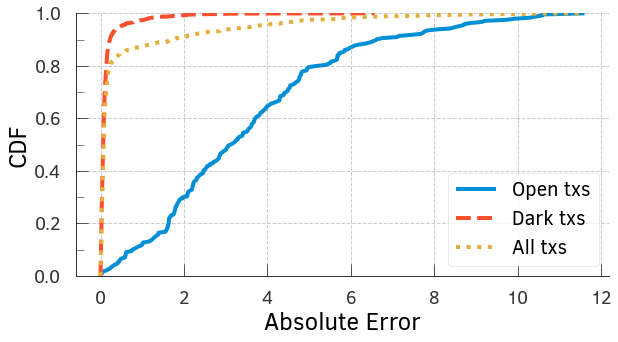

<Figure size 612x324 with 0 Axes>

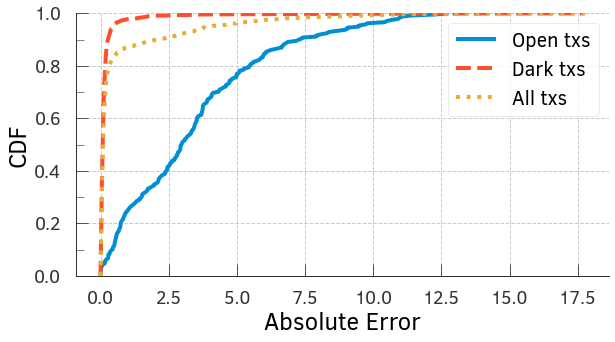

<Figure size 612x324 with 0 Axes>

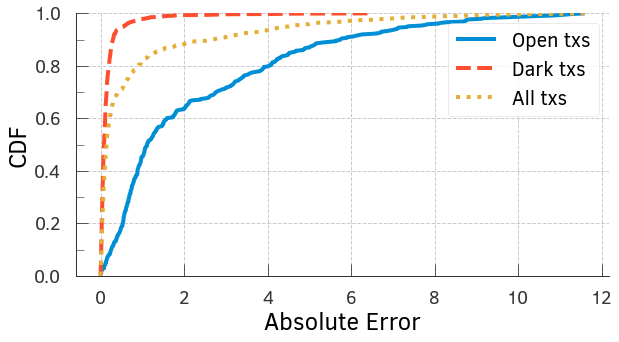

<Figure size 612x324 with 0 Axes>

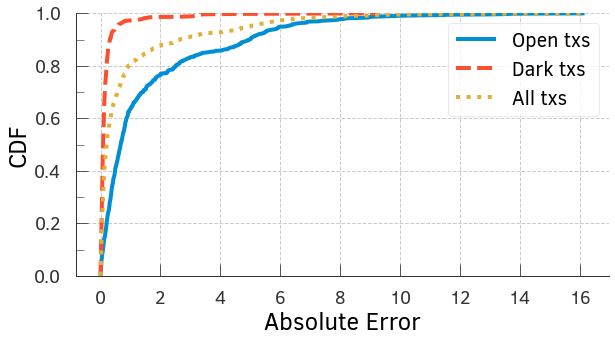

<Figure size 612x324 with 0 Axes>

In [13]:
make_ax_cdf(open_actual_error_4, dark_actual_error_4, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_4_0.35.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_5, dark_actual_error_5, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_5_0.3.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_6, dark_actual_error_6, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_6_0.25.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_7, dark_actual_error_7, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_7_0.2.pdf','Absolute Error',False)




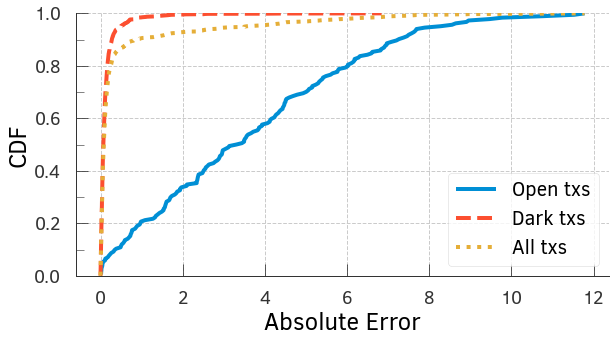

<Figure size 612x324 with 0 Axes>

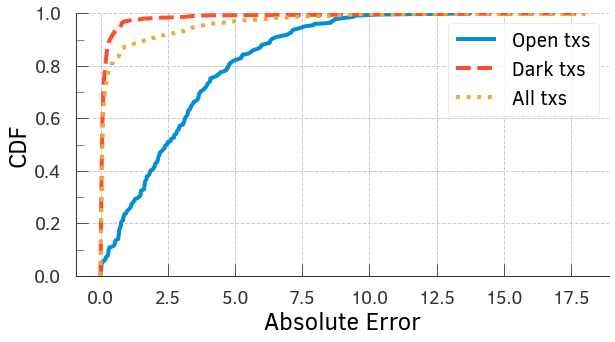

<Figure size 612x324 with 0 Axes>

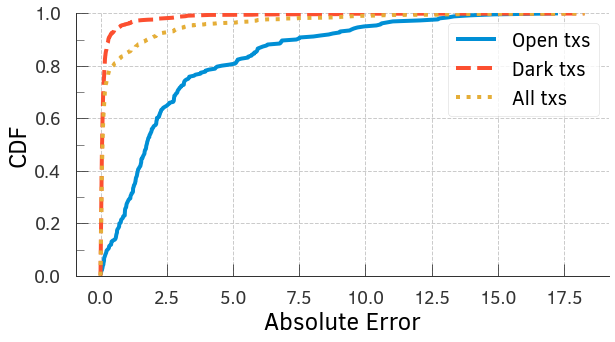

<Figure size 612x324 with 0 Axes>

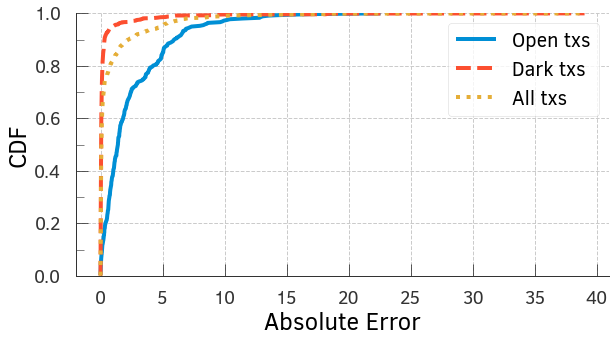

<Figure size 612x324 with 0 Axes>

In [14]:
make_ax_cdf(open_actual_error_4_5, dark_actual_error_4_5, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_4_0.5.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_5_5, dark_actual_error_5_5, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_5_0.5.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_6_5, dark_actual_error_6_5, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_6_0.5.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_7_5, dark_actual_error_7_5, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_7_0.5.pdf','Absolute Error',False)


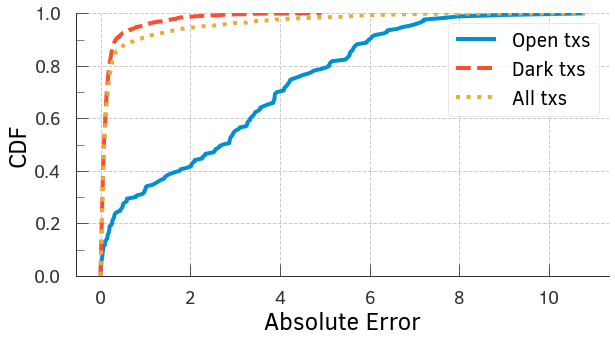

<Figure size 612x324 with 0 Axes>

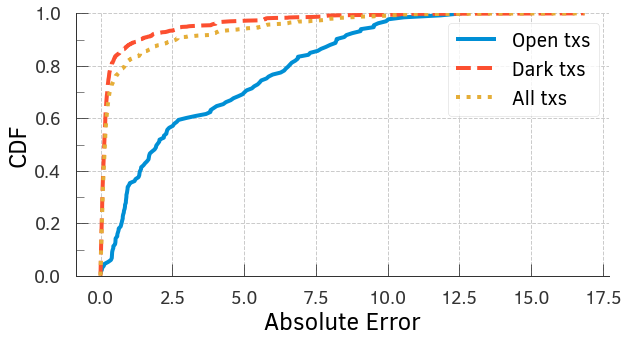

<Figure size 612x324 with 0 Axes>

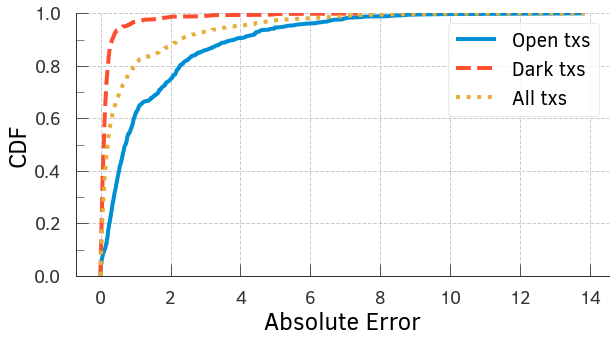

<Figure size 612x324 with 0 Axes>

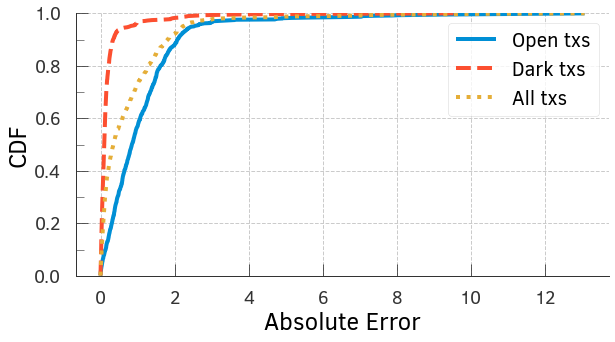

<Figure size 612x324 with 0 Axes>

In [15]:
make_ax_cdf(open_actual_error_4_3, dark_actual_error_4_3, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_4_0.25.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_5_3, dark_actual_error_5_3, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_5_0.2.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_6_3, dark_actual_error_6_3, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_6_0.17.pdf','Absolute Error',False)
make_ax_cdf(open_actual_error_7_3, dark_actual_error_7_3, 'wfq_pickle_files/figures_for_paper/error/Actual_Error_ALL_CDF_7_0.1455.pdf','Absolute Error',False)


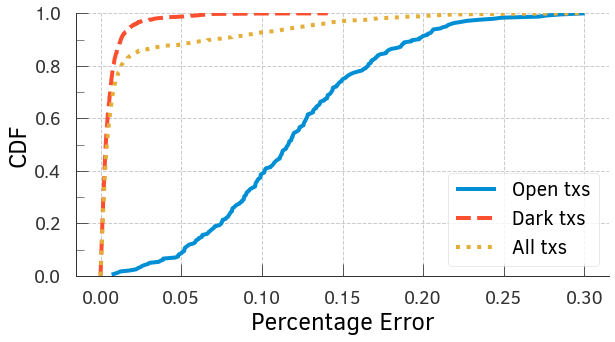

<Figure size 612x324 with 0 Axes>

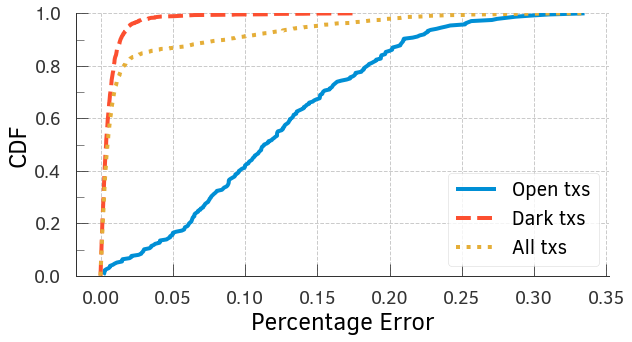

<Figure size 612x324 with 0 Axes>

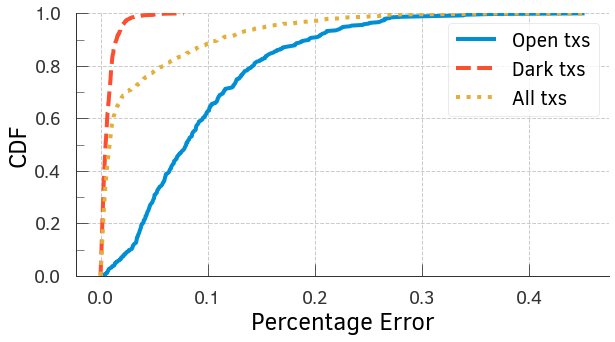

<Figure size 612x324 with 0 Axes>

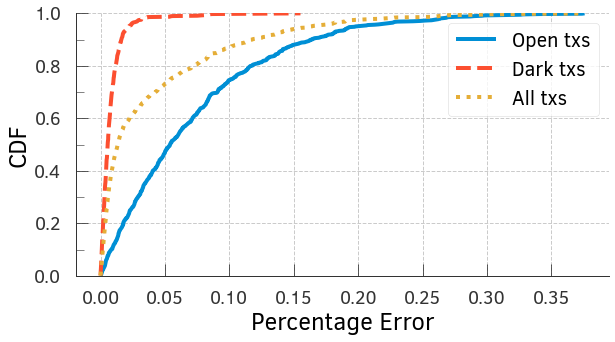

<Figure size 612x324 with 0 Axes>

In [21]:

make_ax_cdf(open_perc_error_4, dark_perc_error_4, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_4_0.35.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_5, dark_perc_error_5, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_5_0.3.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_6, dark_perc_error_6, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_6_0.25.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_7, dark_perc_error_7, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_7_0.2.pdf','Percentage Error',False)



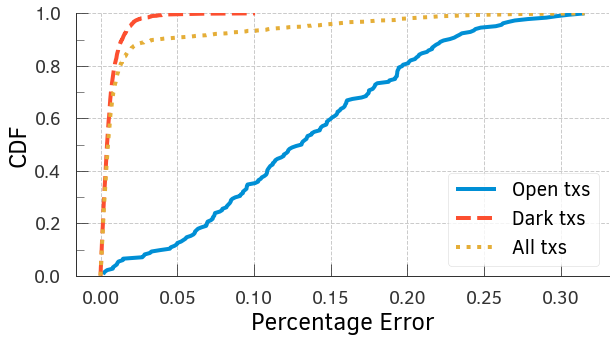

<Figure size 612x324 with 0 Axes>

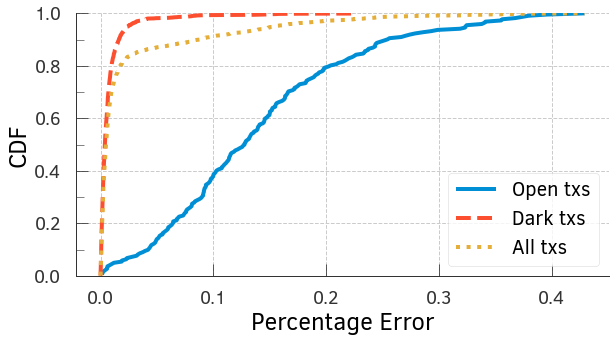

<Figure size 612x324 with 0 Axes>

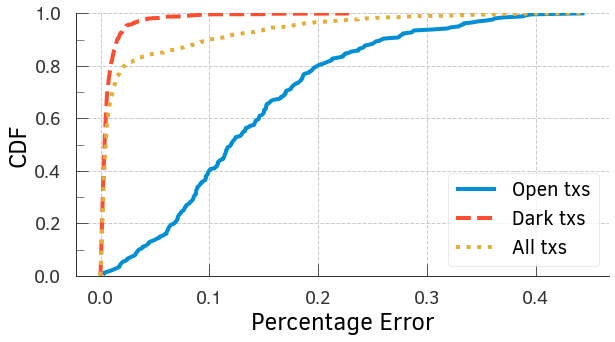

<Figure size 612x324 with 0 Axes>

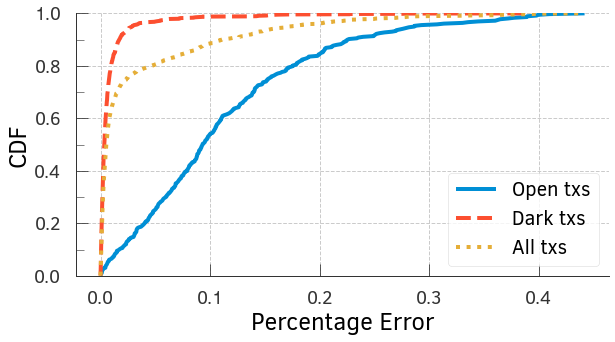

<Figure size 612x324 with 0 Axes>

In [20]:

make_ax_cdf(open_perc_error_4_5, dark_perc_error_4_5, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_4_0.5.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_5_5, dark_perc_error_5_5, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_5_0.5.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_6_5, dark_perc_error_6_5, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_6_0.5.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_7_5, dark_perc_error_7_5, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_7_0.5.pdf','Percentage Error',False)


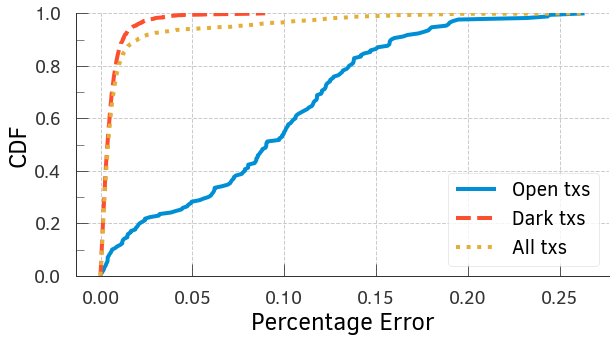

<Figure size 612x324 with 0 Axes>

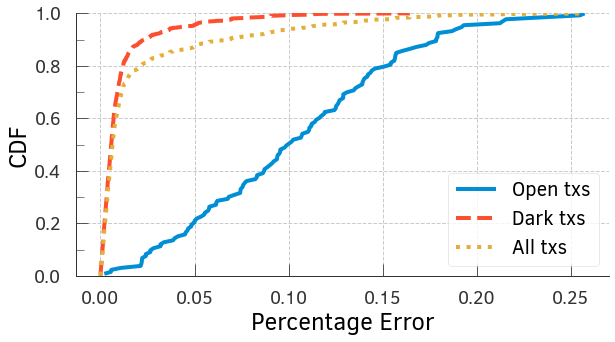

<Figure size 612x324 with 0 Axes>

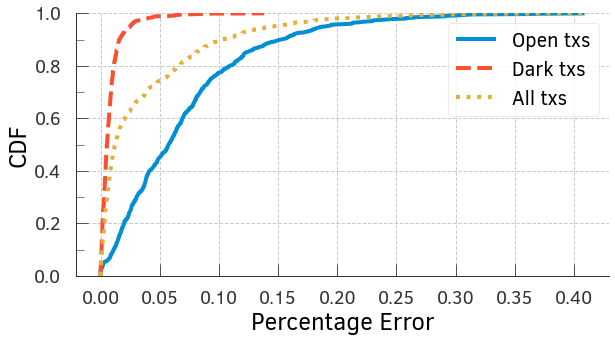

<Figure size 612x324 with 0 Axes>

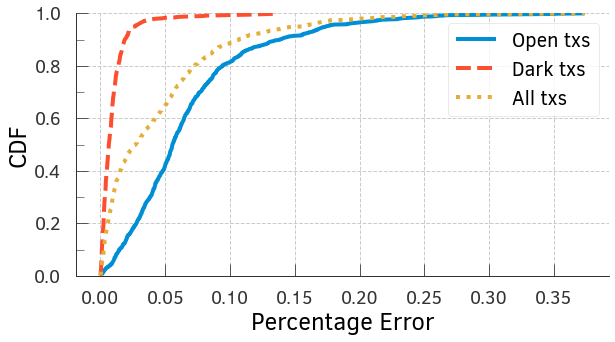

<Figure size 612x324 with 0 Axes>

In [19]:

make_ax_cdf(open_perc_error_4_3, dark_perc_error_4_3, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_4_0.25.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_5_3, dark_perc_error_5_3, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_5_0.2.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_6_3, dark_perc_error_6_3, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_6_0.17.pdf','Percentage Error',False)
make_ax_cdf(open_perc_error_7_3, dark_perc_error_7_3, 'wfq_pickle_files/figures_for_paper/error/Percentage_Error_ALL_CDF_7_0.1455.pdf','Percentage Error',False)
